Necessary Imports

In [11]:
import os
import sys
import pandas as pd
import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score

sys.path.append(os.path.abspath(os.path.join('..', '..', 'models', 'cnn')))
from cnn import CNN
from multilabel_cnn import MultiLabelCNN


Implement a function load mnist data() that extracts images from the
dataset folders and organizes them into separate lists for images and labels
corresponding to the train, validation, and test splits. Ensure that the
images are loaded from their respective folders without any overlap or
mixing.

In [2]:
def one_hot_encode_digit(digit):
    """Creates an 11-dimensional one-hot vector for a single digit or blank."""
    one_hot = np.zeros(11)
    if digit == '*':
        one_hot[10] = 1 
    else:
        one_hot[int(digit)] = 1
    return one_hot

def one_hot_encode_label(label):
    """Encodes the label (up to three digits) as a 33-dimensional vector."""
    label_str = str(label).ljust(3, '*')
    one_hot_encoded = np.concatenate([one_hot_encode_digit(digit) for digit in label_str])
    return one_hot_encoded


def load_mnist_data(base_path='../../data/external/double_mnist', use_label_count=False):
    images = {
        'train': [],
        'val': [],
        'test': []
    }
    labels = {
        'train': [],
        'val': [],
        'test': []
    }

    splits = ['train', 'val', 'test']
    for split in splits:
        split_path = os.path.join(base_path, split)
        for label in os.listdir(split_path):
            label_path = os.path.join(split_path, label)
            if os.path.isdir(label_path):
                for img_name in os.listdir(label_path):
                    img_path = os.path.join(label_path, img_name)
                    img = Image.open(img_path).convert('L')
                    img_array = np.array(img)
                    images[split].append(img_array)

                    if use_label_count:
                        if label == "0":
                            label_count = 0
                        else:
                            label_count = len(label)
                        labels[split].append(label_count)
                    else:
                        labels[split].append(one_hot_encode_label(label))

    return images, labels

images, labels = load_mnist_data(use_label_count=True)


Create a class called MultiMNISTDataset that will be used to create
dataloaders for training and evaluation purposes.

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class MultiMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        
        img = torch.tensor(img, dtype=torch.float32) / 255.0  

        if self.transform:
            img = self.transform(img)

        return img, label

transform = transforms.Compose([
    transforms.ToPILImage(),         
    transforms.Resize((28, 28)),     
    transforms.ToTensor(),         
])

train_dataset = MultiMNISTDataset(images['train'], labels['train'], transform=transform)
val_dataset = MultiMNISTDataset(images['val'], labels['val'], transform=transform)
test_dataset = MultiMNISTDataset(images['test'], labels['test'], transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Implement the CNN Class

Training Epoch 1/5: 100%|██████████| 394/394 [00:12<00:00, 30.99it/s]


Epoch [1/5], Training Loss: 0.2911, Validation Loss: 0.0789


Training Epoch 2/5: 100%|██████████| 394/394 [00:12<00:00, 32.80it/s]


Epoch [2/5], Training Loss: 0.1411, Validation Loss: 0.0647


Training Epoch 3/5: 100%|██████████| 394/394 [00:11<00:00, 34.13it/s]


Epoch [3/5], Training Loss: 0.1148, Validation Loss: 0.0397


Training Epoch 4/5: 100%|██████████| 394/394 [00:09<00:00, 42.98it/s]


Epoch [4/5], Training Loss: 0.0996, Validation Loss: 0.0410


Training Epoch 5/5: 100%|██████████| 394/394 [00:09<00:00, 39.48it/s]


Epoch [5/5], Training Loss: 0.0881, Validation Loss: 0.0244


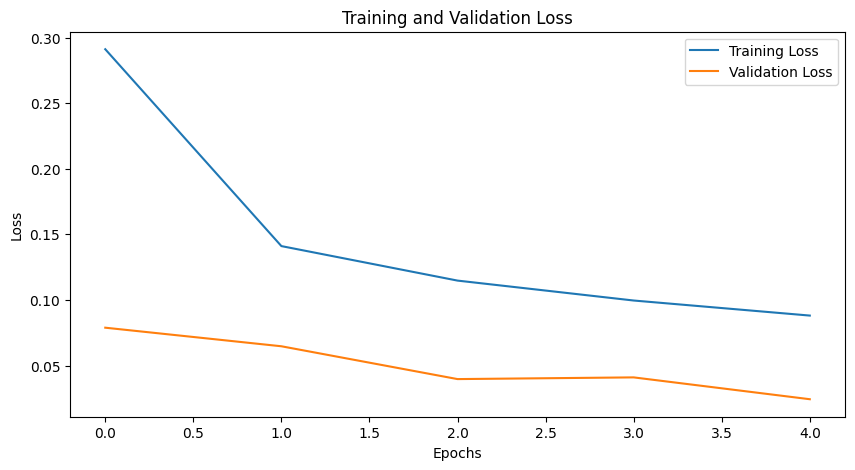

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(task='regression', num_classes=4, num_conv_layers=1,dropout_rate=0.5, optimizer_choice='adam', device=device).to(device)
model.fit(train_loader, val_loader, epochs=5, lr=0.001)

In [14]:
import pandas as pd
import torch
from sklearn.metrics import accuracy_score

def calculate_accuracy(model, test_loader, output_file='predictions.csv'):
    model.eval()
    predictions = model.predict(test_loader)
    
    true_labels = []
    for _, labels in test_loader:
        true_labels.append(labels)
    true_labels = torch.cat(true_labels).cpu()
    predictions = torch.round(predictions).cpu()
    
    # Create a DataFrame to display true labels, predictions, and correctness
    results_df = pd.DataFrame({
        'True Labels': true_labels.numpy(),
        'Predictions': predictions.numpy(),
        'Correctness': ['✓' if true == pred else 'x' for true, pred in zip(true_labels.numpy(), predictions.numpy())]
    })
    
    print(results_df.head())
    results_df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")
    
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy

accuracy = calculate_accuracy(model, test_loader)


   True Labels  Predictions Correctness
0            3            3           ✓
1            3            3           ✓
2            3            3           ✓
3            3            3           ✓
4            3            3           ✓
Results saved to predictions.csv
Test Accuracy: 0.9972


In [ ]:
images, labels = load_mnist_data(use_label_count=False)

train_dataset = MultiMNISTDataset(images['train'], labels['train'], transform=transform)
val_dataset = MultiMNISTDataset(images['val'], labels['val'], transform=transform)
test_dataset = MultiMNISTDataset(images['test'], labels['test'], transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiLabelCNN(device=device).to(device)
model.fit(train_loader, val_loader, epochs=1, lr=0.001)

Training Epoch 1/1: 100%|██████████| 394/394 [00:10<00:00, 38.29it/s]


Epoch [1/1], Training Loss: 5.0081
Epoch [1/1], Validation Loss: 5.4087


In [ ]:
def exact_match_accuracy(preds, labels):
    """Calculates the exact match accuracy between predictions and labels."""
    return (preds == labels).all(dim=1).float().mean().item()

def hamming_accuracy(preds, labels):
    """Calculates the Hamming accuracy for multi-label predictions."""
    return (preds == labels).float().mean().item()


def evaluate_model(model, test_loader):
    preds = model.predict(test_loader)
    labels = torch.cat([labels for _, labels in test_loader])
    print(preds[12], labels[12])

    exact_acc = exact_match_accuracy(preds, labels)
    hamming_acc = hamming_accuracy(preds, labels)
    print(f"Exact Match Accuracy: {exact_acc * 100:.2f}%")
    print(f"Hamming Accuracy: {hamming_acc * 100:.2f}%")

evaluate_model(model, test_loader)


tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]) tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)
Exact Match Accuracy: 2.70%
Hamming Accuracy: 89.62%
